Train AD with vectors generated by Pytorch FE

In [5]:
import os 
os.chdir("./Kitsune/")
from netStat_torch import netStat
import AfterImage_torch as af

os.chdir("..")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
import pickle
from utils import get_feature_map, load_data
from PytorchAD import AnomalyDetector
import time
import datetime
import copy

Feature extractor

In [6]:
packages = pickle.load(open("data/videoinj_packages.pkl", "rb"))
maxHost = 100000000000
maxSess = 100000000000
Lambdas = torch.tensor([5., 3., 1., .1, .01])
nstat = netStat(Lambdas, maxHost, maxSess)
videoinj_new = []
t0 = time.time()
ts0 = packages[0][-1] # start timestamp

save_nstat_checkpoint = False # save nstat checkpoints every 10000 iters, useful for analysis of nstat objects

for i in range(len(packages)):
    if (i+1) % 10000 == 0:
        print("Finished {}. Time: {}s.".format(i+1, time.time()-t0))
        t0 = time.time()
        if save_nstat_checkpoint:
            pickle.dump(nstat, open("nstat_torch_save/FE_chkpt/nstat_idx_{}.pkl".format(i), "wb"))
    IPtype, srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp = packages[i]
    datagramSize = torch.tensor(datagramSize).float()
    timestamp = torch.tensor(timestamp - ts0) # due to lack of precision of torch.DoubleTensor 
    new_inst = nstat.updateGetStats(srcMAC, dstMAC, srcIP, srcProtocol, dstIP, dstProtocol, datagramSize, timestamp)
    videoinj_new.append(new_inst.reshape(1,-1))

videoinj_torch = torch.cat(videoinj_new)

Finished 10000. Time: 17.005043268203735s.
Finished 20000. Time: 17.44424057006836s.
Finished 30000. Time: 17.658437728881836s.
Finished 40000. Time: 18.04863691329956s.
Finished 50000. Time: 18.471635103225708s.
Finished 60000. Time: 18.302836656570435s.
Finished 70000. Time: 18.211236715316772s.
Finished 80000. Time: 18.253437280654907s.
Finished 90000. Time: 18.308440446853638s.
Finished 100000. Time: 18.27283501625061s.
Finished 110000. Time: 18.316238403320312s.
Finished 120000. Time: 18.288835763931274s.
Finished 130000. Time: 18.271235704421997s.
Finished 140000. Time: 18.23403549194336s.
Finished 150000. Time: 18.27083921432495s.
Finished 160000. Time: 18.23583698272705s.
Finished 170000. Time: 18.289435148239136s.
Finished 180000. Time: 18.237837314605713s.
Finished 190000. Time: 18.241837739944458s.
Finished 200000. Time: 18.254234552383423s.
Finished 210000. Time: 18.30223774909973s.
Finished 220000. Time: 18.596840381622314s.
Finished 230000. Time: 18.664297819137573s.
Fini

In [8]:
saveInputs = True
if saveInputs:
    pickle.dump(videoinj_torch, open("data/videoinj_vector.pkl", "wb"))

Train AD

In [10]:
# KitNET params
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 100000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 1000000 #the number of instances used to train the anomaly detector (ensemble itself)

# Train FM and initialize AD
v = get_feature_map(videoinj_torch.numpy(), FMgrace, maxAE)
AD = AnomalyDetector(v, device="cpu")
#AD.load_state_dict(torch.load("AD_model_mirai_state_dict.pt"))
#AD = torch.load("model/AD_model_mirai.pt")
AD.eval()

AnomalyDetector(
  (ensemble_layer): ModuleList(
    (0): Autoencoder()
    (1): Autoencoder()
    (2): Autoencoder()
    (3): Autoencoder()
    (4): Autoencoder()
    (5): Autoencoder()
    (6): Autoencoder()
    (7): Autoencoder()
    (8): Autoencoder()
    (9): Autoencoder()
    (10): Autoencoder()
    (11): Autoencoder()
    (12): Autoencoder()
    (13): Autoencoder()
    (14): Autoencoder()
    (15): Autoencoder()
    (16): Autoencoder()
    (17): Autoencoder()
    (18): Autoencoder()
    (19): Autoencoder()
  )
  (output_layer): Autoencoder()
)

In [11]:
train_AD_data = videoinj_torch[FMgrace+1:FMgrace+ADgrace+1].double()

optimizer = SGD(AD.parameters(), lr=0.1)
AD.train()

t0 = time.time()
for i, x in enumerate(train_AD_data):
    if (i+1)%1000 == 0:
        print(i+1,"/",len(train_AD_data),", time: ",time.time()-t0,"s")
        t0 = time.time()
        
    z_list = AD(x.reshape(1,-1))
    optimizer.zero_grad()
    for i, error in enumerate(z_list):
        error.backward()
        optimizer.step()


1000 / 1000000 , time:  15.591432332992554 s
2000 / 1000000 , time:  14.387432336807251 s
3000 / 1000000 , time:  14.24683403968811 s
4000 / 1000000 , time:  14.19562816619873 s
5000 / 1000000 , time:  14.24323034286499 s
6000 / 1000000 , time:  14.151828527450562 s
7000 / 1000000 , time:  14.13862943649292 s
8000 / 1000000 , time:  14.406662702560425 s
9000 / 1000000 , time:  14.461307525634766 s
10000 / 1000000 , time:  14.207051515579224 s
11000 / 1000000 , time:  14.2903151512146 s
12000 / 1000000 , time:  14.191434383392334 s
13000 / 1000000 , time:  14.135430812835693 s
14000 / 1000000 , time:  14.379199743270874 s
15000 / 1000000 , time:  14.206460952758789 s
16000 / 1000000 , time:  13.948428869247437 s
17000 / 1000000 , time:  13.960628032684326 s
18000 / 1000000 , time:  14.121632814407349 s
19000 / 1000000 , time:  13.954028367996216 s
20000 / 1000000 , time:  13.96262812614441 s
21000 / 1000000 , time:  14.015251636505127 s
22000 / 1000000 , time:  14.07083249092102 s
23000

In [12]:
eval_AD_data = videoinj_torch[FMgrace+ADgrace+1:].double()
AD.eval()
RMSEs = list(np.zeros(FMgrace+ADgrace+1)) + AD(eval_AD_data).tolist()

C:\Users\qiuhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Plotting results


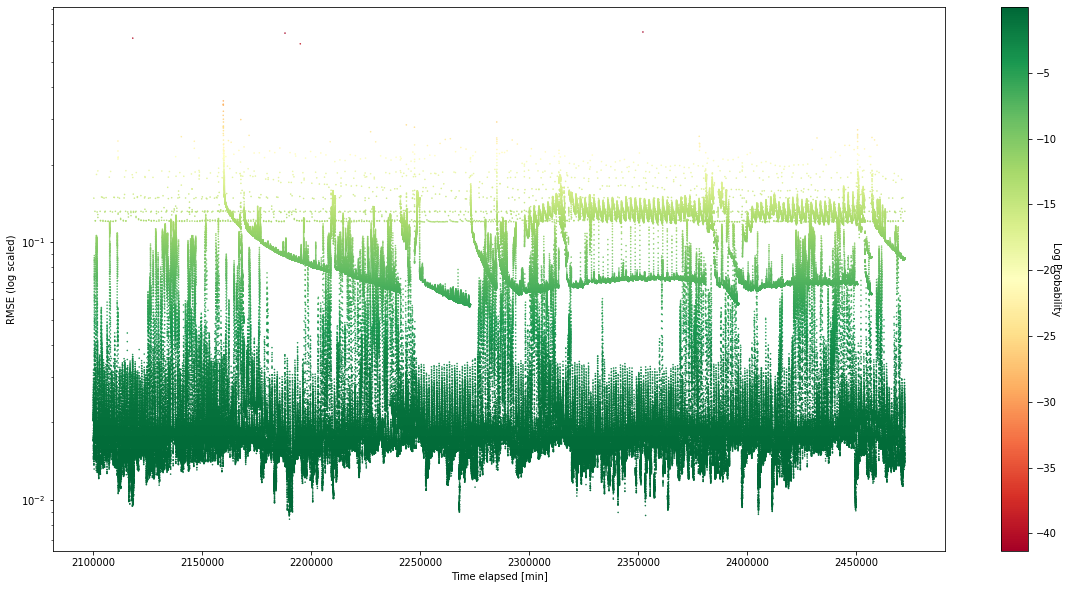

In [18]:
# Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold \phi)
from scipy.stats import norm
benignSample = np.log(RMSEs[2100000:2131051])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample))

# plot the RMSE anomaly scores
print("Plotting results")
from matplotlib import pyplot as plt
from matplotlib import cm
plt.figure(figsize=(20,10))
fig = plt.scatter(range(2100000,len(RMSEs)),RMSEs[2100000:],s=0.3,c=logProbs[2100000:],cmap='RdYlGn')
plt.yscale("log")
#plt.title("Anomaly Scores from Kitsune's Execution Phase")
plt.ylabel("RMSE (log scaled)")
plt.xlabel("Time elapsed [min]")
#plt.annotate('Mirai C&C channel opened [Telnet]', xy=(121662,RMSEs[121662]), xytext=(151662,1),arrowprops=dict(facecolor='black', shrink=0.05),)
#plt.annotate('Mirai Bot Activated\nMirai scans network\nfor vulnerable devices', xy=(122662,10), xytext=(122662,150),arrowprops=dict(facecolor='black', shrink=0.05),)
#plt.annotate('Mirai Bot launches DoS attack', xy=(370000,10000), xytext=(390000,1000),arrowprops=dict(facecolor='black', shrink=0.05),)
figbar=plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n ', rotation=270)
plt.savefig("result/pytorch_videoinj_result.png")
plt.show()

Save state dict of model

In [39]:
torch.save(AD.state_dict(), "model/AD_model_state_dict.pt")
torch.save(AD, "model/AD_model.pt")